In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv("../source_coin_data/coinbaseUSD_1-min_data.csv", header=0)
df = df[-100000:]
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)

In [4]:
df.head()

,open,high,low,close,volume
Date,,,,,
2024-05-21 06:21:00+00:00,71089.71,71153.75,71089.71,71153.75,4.900671
2024-05-21 06:22:00+00:00,71153.75,71192.19,71152.42,71192.18,4.749921
2024-05-21 06:23:00+00:00,71192.19,71242.46,71189.27,71193.15,11.620343
2024-05-21 06:24:00+00:00,71193.66,71202.80,71138.44,71183.10,8.889186
2024-05-21 06:25:00+00:00,71183.09,71209.05,71170.96,71197.70,6.446220


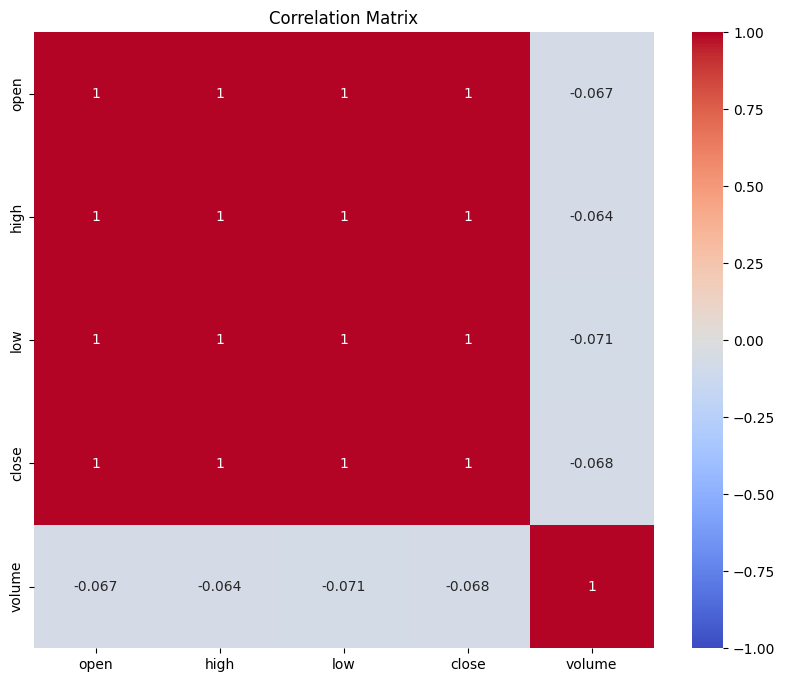

In [5]:
correlation_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [6]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [11]:
help(ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [14]:
help(ta.bbands)

Help on function bbands in module pandas_ta.volatility.bbands:

bbands(close, length=None, std=None, ddof=0, mamode=None, talib=None, offset=None, **kwargs)
    Bollinger Bands (BBANDS)
    
    A popular volatility indicator by John Bollinger.
    
    Sources:
        https://www.tradingview.com/wiki/Bollinger_Bands_(BB)
    
    Calculation:
        Default Inputs:
            length=5, std=2, mamode="sma", ddof=0
        EMA = Exponential Moving Average
        SMA = Simple Moving Average
        STDEV = Standard Deviation
        stdev = STDEV(close, length, ddof)
        if "ema":
            MID = EMA(close, length)
        else:
            MID = SMA(close, length)
    
        LOWER = MID - std * stdev
        UPPER = MID + std * stdev
    
        BANDWIDTH = 100 * (UPPER - LOWER) / MID
        PERCENT = (close - LOWER) / (UPPER - LOWER)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): The short period. Default: 5
        std (int): The long 

In [2]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

In [7]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
df['RSI'] = ta.rsi(df.close, length=16)
my_bbands = ta.bbands(df.close, length=14, std=2.0)
macd = ta.macd(df.close)

# test_data = df[-55:]
# df = df[50:-55]

C:\Users\Pc\AppData\Local\Temp\ipykernel_17368\1807763412.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [10]:
print(macd)

                           MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9
Date                                                                 
2023-10-25 21:56:00+00:00           NaN            NaN            NaN
2023-10-25 21:57:00+00:00           NaN            NaN            NaN
2023-10-25 21:58:00+00:00           NaN            NaN            NaN
2023-10-25 21:59:00+00:00           NaN            NaN            NaN
2023-10-25 22:00:00+00:00           NaN            NaN            NaN
...                                 ...            ...            ...
2024-07-29 18:03:00+00:00     43.495839      12.639496      30.856343
2024-07-29 18:04:00+00:00     53.044920      17.750862      35.294058
2024-07-29 18:05:00+00:00     61.735911      21.153482      40.582429
2024-07-29 18:06:00+00:00     67.915736      21.866646      46.049090
2024-07-29 18:07:00+00:00     74.192400      22.514648      51.677752

[400000 rows x 3 columns]


In [10]:
df = pd.concat([df, my_bbands, macd], axis=1)

In [11]:
df.head()

,open,high,low,close,volume,VWAP,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,
2024-05-21 06:21:00+00:00,71089.71,71153.75,71089.71,71153.75,4.900671,71132.403333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:22:00+00:00,71153.75,71192.19,71152.42,71192.18,4.749921,71155.303275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:23:00+00:00,71192.19,71242.46,71189.27,71193.15,11.620343,71184.251822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:24:00+00:00,71193.66,71202.80,71138.44,71183.10,8.889186,71181.460162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21 06:25:00+00:00,71183.09,71209.05,71170.96,71197.70,6.446220,71183.416557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999975  0.999971  0.999956 -0.067139  0.994400   
high           0.999975  1.000000  0.999955  0.999977 -0.064231  0.994402   
low            0.999971  0.999955  1.000000  0.999976 -0.070841  0.994318   
close          0.999956  0.999977  0.999976  1.000000 -0.067528  0.994364   
volume        -0.067139 -0.064231 -0.070841 -0.067528  1.000000 -0.062438   
VWAP           0.994400  0.994402  0.994318  0.994364 -0.062438  1.000000   
RSI            0.012618  0.014095  0.014586  0.015591 -0.021809 -0.018604   
BBL_14_2.0     0.999726  0.999660  0.999745  0.999691 -0.074742  0.994392   
BBM_14_2.0     0.999859  0.999842  0.999826  0.999823 -0.066454  0.994670   
BBU_14_2.0     0.999686  0.999719  0.999602  0.999649 -0.058117  0.994644   
BBB_14_2.0    -0.191526 -0.188777 -0.194401 -0.191569  0.477387 -0.182343   
BBP_14_2.0     0.002361  0.004501  0.004810  0.006532 -0.016683 -0.011357   

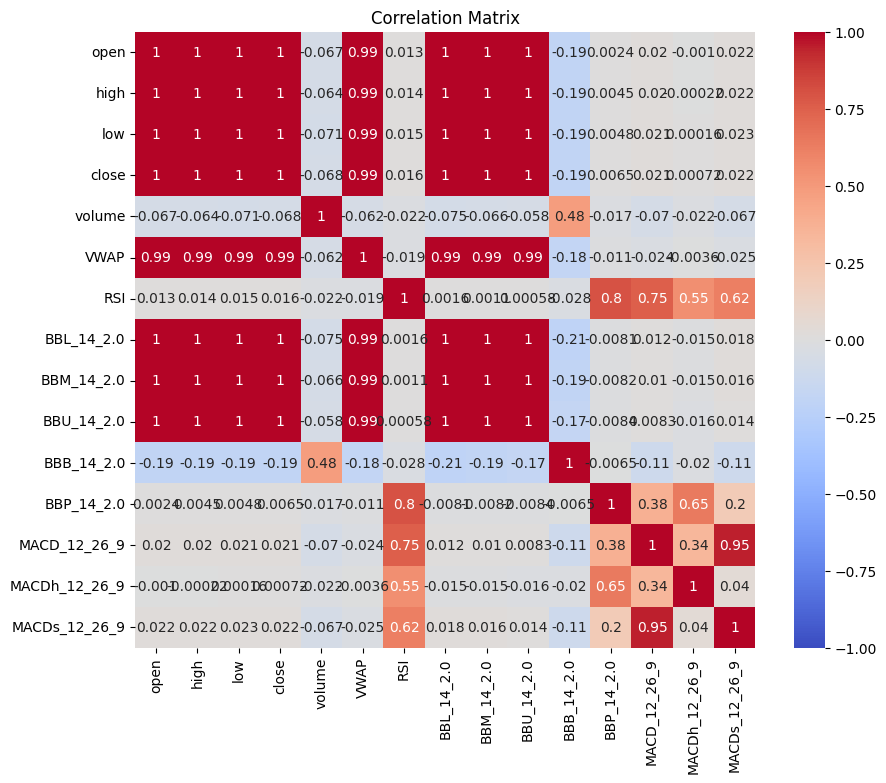

In [13]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()